# Net3 model: Training individual facial features as models
## Loading pre-trained model.

In [38]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
import tensorflow as tf

### Get data and load

In [3]:
FROOT = os.getcwd() 
FTRAIN = FROOT + '/data/training.csv'
FTEST = FROOT + '/data/test.csv'

def load(test = False, cols = None):
    """
    Loads the data. Gets training data by default. 
    cols = None gets all columns. 
    cols  is set to individual column names using the facial_group_col in facial_group_settings
    function. This parameter is set only while training individual facial group models.
    
    Returns a tuple(X,y) for training, y has none for test.
      
    """
    
    if test:
        fname = FTEST 
    else: 
        fname =FTRAIN
        
    df = read_csv(os.path.expanduser(fname))  

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them
    
    # Normalize pixel values to be within [0, 1]
    X = np.vstack(df['Image'].values) / 255. 
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        
        #shuffle train data
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]

        
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

    
X, y = load()



left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [11]:
num_channels = 1 # grayscale
image_size = 96
#load2d reshapes the data to be used for convolutional layers
def load2d(test = False, cols = None):
    X, y = load(test = test, cols = cols)
    X = X.reshape(-1, image_size, image_size, num_channels)
    return X, y




## Individual model settings

On examining the number of datapoints available for each feature, individual models are made by grouping similar features based on number of data points availabe. the main idea being to maximize use of data. Below is the reasoning behind combining different labels.

1. First I considered putting all eye data into one model, but as we can see above that left_eye_center_x, left_eye_center_y, right_eye_center_x , right_eye_center_y have more than 7000 data points while the remining
eye data points only have 2267 - 2271 data points. So eye data points have been split into two models namely eye center and eye corner.
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036

#### Facial_group_models - Thirty keypoints have been grouped in six types to create specialized models
#### These specialized models are eye_center, eye_corners, nose_tip, mouth_corner_top, mouth_bottom and eyebrow.

In [4]:
#Uncomment the dict to run a particular model
facial_group_labels = [
   
    dict(
        name = "mouth_corner_top",
        columns = (
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            )),
     
#      dict(
#          name = "nose_tip",
#          columns = (
#              'nose_tip_x', 'nose_tip_y',
#              )),

#     dict(
#         name = "mouth_bottom",
#         columns = (
#             'mouth_center_bottom_lip_x',
#             'mouth_center_bottom_lip_y',
#             )),

#     dict(
#         name = "eye_corner",
#         columns = (
#             'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
#             'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
#             'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
#             'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
#             )),
#
    dict(
        name = "eyebrow",
        columns = (
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            )),
    
#      dict(
#         name = "eye_center",
#         columns = (
#             'left_eye_center_x', 'left_eye_center_y',
#             'right_eye_center_x', 'right_eye_center_y',
#             )),
    ]    

## Functions

In [5]:
#creating file path to store individual facial model data

root_location = FROOT + "/models/"


def model_name(facial_model_name):
    return "model_" + facial_model_name

def model_path(facial_model_name):
    return root_location + "ind_models/" + model_name(facial_model_name) + "/model.ckpt"

def train_history_path(facial_model_name):
    return root_location + "ind_models/" + model_name(facial_model_name) + "/train_history"

def create_directory_for_specialist(facial_model_name):
    return os.makedirs(root_location + "ind_models/" + model_name(facial_model_name) + "/", exist_ok = True)

In [6]:
def plot_sample(x, y, axis):
    """
    To visualize images with keypoints.
    Note that it also takes in axis parameter   
    """
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

In [7]:
#Defining functions for different layers to be used in the network

def fully_connected(input, nodes):
    
    # Creates a fully connected layer initializing Weight W with Xavier initializer 
    # and bias b with constant initializer
    #Input is the 4 dimension and nodes is number of units in the fully connected layer.
    
    
    weights = tf.get_variable( 'weights', shape = [input.get_shape()[1], nodes],
        initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable( 'biases',shape = [nodes],initializer=tf.constant_initializer(0.0))
    return tf.matmul(input, weights) + biases

def fully_connected_relu(input, size):
    #Creates a fully connected TensorFlow layer with ReLU activation applied.
    return tf.nn.relu(fully_connected(input, size))

def conv_relu(input, kernel_size, depth):
    #Creates a convolutional TensorFlow layer and applies  ReLU activation function to it.
    #Input is 4 dimensions
    #
    weights = tf.get_variable( 'weights', shape = [kernel_size, kernel_size, input.get_shape()[3], depth],
        initializer = tf.contrib.layers.xavier_initializer())
    
    biases = tf.get_variable( 'biases',shape = [depth],initializer=tf.constant_initializer(0.0))
    conv = tf.nn.conv2d(input, weights,strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv + biases)

In [8]:
#define our convolutional layers here.

def conv_flow(input, keypoints, training):
    
    # Convolutional layers
    with tf.variable_scope('conv1'):
        #Input is (num of rows, 96, 96, 1)
        conv1 = conv_relu(input, kernel_size = 3, depth = 32) 
        
        #shape of conv1 should be ( num of rows, 96, 96,depth ofconv1)
        pool1 =tf.nn.max_pool(conv1,ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')
        
        
        # Apply dropout if needed
        
        #tf.cond is a conditional check. If training is true, then apply keep_prob, else don't apply it.
        pool1 = tf.cond(training, lambda: tf.nn.dropout(pool1, keep_prob = 0.9), lambda: pool1)
    with tf.variable_scope('conv2'):
        conv2 = conv_relu(pool1, kernel_size = 2, depth = 64)
        
        pool2 =tf.nn.max_pool(conv2,ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')
        
        # Apply dropout if needed
        pool2 = tf.cond(training, lambda: tf.nn.dropout(pool2, keep_prob = 0.8), lambda: pool2)
    with tf.variable_scope('conv3'):
        conv3 = conv_relu(pool2, kernel_size = 2, depth = 128)
        pool3 =tf.nn.max_pool(conv3,ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')
        # Apply dropout if needed
        pool3 = tf.cond(training, lambda: tf.nn.dropout(pool3, keep_prob = 0.7), lambda: pool3)
    
    # Flatten convolutional layers output
    shape = pool3.get_shape().as_list()
    flattened = tf.reshape(pool3, [-1, shape[1] * shape[2] * shape[3]])
    
    # Fully connected layers
    with tf.variable_scope('fc4'):
        fc4 = fully_connected_relu(flattened, 1000)
        
        # Apply dropout if needed
        fc4 = tf.cond(training, lambda: tf.nn.dropout(fc4, keep_prob = 0.5), lambda: fc4)
    with tf.variable_scope('fc5'):
        #We have 1000 units in our fully connected layer
        fc5 = fully_connected_relu(fc4, 1000)
    with tf.variable_scope('out'):
        #the output layer is just a fully connected layer with 30 nodes for the keypoints
        prediction = fully_connected(fc5, keypoints)
    return prediction

## Training

In [43]:
# parameters
batch_size = 128
every_epoch_to_log = 5

def train_individual_model(facial_model_label):
    
            
    # Load data for the group( groups are nose_tip, eye_center etc each with their own set of keypoints) 
    #and split into train, test & dev datasets
    X, y = load2d(cols = facial_model_label['columns'])
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)    

    # prepare the file paths
    feature_name = facial_model_label['name']
    create_directory_for_specialist(feature_name)
    spec_var_scope = model_name(feature_name)
    initialising_model = "3con_2fc_b36_e9_aug_lrdec_mominc_dr"

    # Calculate some of the training hyperparameters based on the specialist and available data
    
    max_epochs = 5
    num_keypoints = y.shape[1]
    
    # training time start
    time_start = time.time()
    
    # Build the graph
    graph = tf.Graph()
    with graph.as_default():
        # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
        tf_x_batch = tf.placeholder(tf.float32, shape = (None, image_size, image_size, num_channels))
        tf_y_batch = tf.placeholder(tf.float32, shape = (None, num_keypoints))
        is_training = tf.placeholder(tf.bool)
        
        current_epoch = tf.Variable(0)  # count the number of epochs

        # learning rate decay. - Idea is to start with high learning rate to speed up but decrease as we get closer to 
        #the local optimum so that we don't surpass it.
        learning_rate = tf.train.exponential_decay(0.03, current_epoch, decay_steps = max_epochs, decay_rate = 0.03)
        momentum = 0.9 + (0.99 - 0.9) * (current_epoch / max_epochs)

        # Training computation.
        with tf.variable_scope(spec_var_scope):
            predictions = conv_flow(tf_x_batch, num_keypoints, is_training)

        loss = tf.reduce_mean(tf.square(predictions - tf_y_batch))

        # Optimizer.
        optimizer = tf.train.MomentumOptimizer(
            learning_rate = learning_rate, 
            momentum = momentum, 
            use_nesterov = True
        ).minimize(loss)
    
    # Initiate training
    with tf.Session(graph = graph) as session:
        session.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        train_loss_history = np.zeros(max_epochs)
        valid_loss_history = np.zeros(max_epochs)
        test_pred = np.zeros((x_test.shape[0],y.shape[1]))
        
        print(" RESTORING SESSION FOR WEIGHTS INITIALIZATION")
        # Exclude output layer weights from variables we will restore
        variables_to_restore = [v for v in tf.global_variables() if "/out/" not in v.op.name]
        # Replace variables scope with that of the current model
        loader = tf.train.Saver({v.op.name.replace(spec_var_scope, initialising_model): v for v in variables_to_restore})
        load_path = root_location + initialising_model + "/model.ckpt"
        loader.restore(session, load_path)
        print(" Model loaded from: " + load_path)

        print(" TRAINING: " + feature_name + " on " + str(y.shape[0]) + " EXAMPLES ")
        for epoch in range(max_epochs):
            current_epoch = epoch
            # print("epoch", epoch)
            # Train on whole randomised dataset in batches
            
            #No flipping yet
            
            shuffle = np.random.permutation(np.arange(x_train.shape[0])) #shuffle 
            X, y = x_train[shuffle], y_train[shuffle]
            for i in range(int(X.shape[0]//batch_size)): 
                X_batch,y_batch = X[i*batch_size:(i+1)*batch_size,:],y[i*batch_size:(i+1)*batch_size]
                session.run([optimizer], feed_dict = {
                        tf_x_batch : X_batch, 
                        tf_y_batch : y_batch,
                        is_training : True
                    }
                )

            
            
            # If another significant epoch ended, we log our losses.
            if (epoch % every_epoch_to_log == 0):
                # Get training data predictions and log training loss:
                #training loss for the last batch
                train_loss = loss.eval(feed_dict = {tf_x_batch:X_batch,tf_y_batch:y_batch, is_training : True})
                train_loss_history[epoch] = train_loss
            # Get validation data loss:
                valid_loss = loss.eval(feed_dict = {tf_x_batch:x_valid,tf_y_batch:y_valid, is_training : False})
                valid_loss_history[epoch] = valid_loss
            
                
                 #training time end
                time_stop = time.time()
                
                #since we have lots of epochs,and more data, and many more models, we dispaly losses for every 
                #100 epochs
                if (epoch % 100 == 0):
                    print(" EPOCH %4d/%d " % (epoch, max_epochs))
                    print("Train loss: %.8f" % (train_loss))
                    print("Validation loss: %.8f" % (valid_loss))
                    print("Time: " , time_stop - time_start)
            
            
            
        # Evaluate on test dataset.
        test_loss =  loss.eval(feed_dict = {tf_x_batch:x_test,tf_y_batch:y_test, is_training : False})
        
        #Plot a graph of the train vs test loss data:
    
        plt.plot(train_loss_history, label="train")
        plt.plot(valid_loss_history, linewidth=3, label="valid")
        plt.grid()
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.yscale("log")
        plt.show()
        
        print(feature_name)
        print(" Test score: %.3f (loss = %.8f)" % (np.sqrt(test_loss) * 48.0, test_loss)) 
        print(" Total time: " ,time_stop - time_start )

        # Save model weights for future use.
        save_path = saver.save(session, model_path(feature_name))
        print("Model file: " + save_path)
        np.savez(train_history_path(feature_name), train_loss_history = train_loss_history, valid_loss_history = valid_loss_history)
        print("Train history file: " + train_history_path(feature_name))        
        print("\n")
        
        

mouth_left_corner_x       2269
mouth_left_corner_y       2269
mouth_right_corner_x      2270
mouth_right_corner_y      2270
mouth_center_top_lip_x    2275
mouth_center_top_lip_y    2275
Image                     7049
dtype: int64
 RESTORING SESSION FOR WEIGHTS INITIALIZATION
INFO:tensorflow:Restoring parameters from /Users/anamika/W207_local/class/models/3con_2fc_b36_e9_aug_lrdec_mominc_dr/model.ckpt
 Model loaded from: /Users/anamika/W207_local/class/models/3con_2fc_b36_e9_aug_lrdec_mominc_dr/model.ckpt
 TRAINING: mouth_corner_top on 2260 EXAMPLES 
 EPOCH    0/5 
Train loss: 0.00829276
Validation loss: 0.01423701
Time:  41.626102924346924


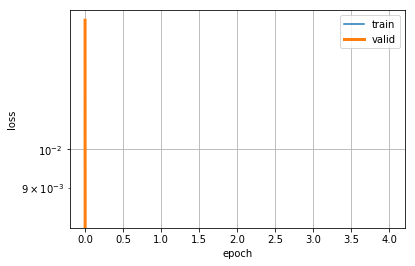

mouth_corner_top
 Test score: 3.927 (loss = 0.00669466)
 Total time:  41.626102924346924
Model file: /Users/anamika/W207_local/class/models/ind_models/model_mouth_corner_top/model.ckpt
Train history file: /Users/anamika/W207_local/class/models/ind_models/model_mouth_corner_top/train_history


nose_tip_x    7049
nose_tip_y    7049
Image         7049
dtype: int64
 RESTORING SESSION FOR WEIGHTS INITIALIZATION
INFO:tensorflow:Restoring parameters from /Users/anamika/W207_local/class/models/3con_2fc_b36_e9_aug_lrdec_mominc_dr/model.ckpt
 Model loaded from: /Users/anamika/W207_local/class/models/3con_2fc_b36_e9_aug_lrdec_mominc_dr/model.ckpt
 TRAINING: nose_tip on 7049 EXAMPLES 
 EPOCH    0/5 
Train loss: 0.01205812
Validation loss: 0.01127749
Time:  129.74994206428528


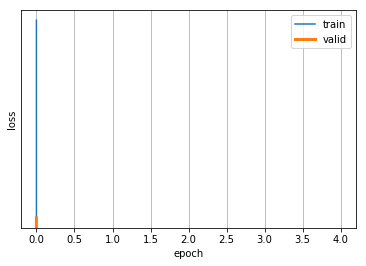

nose_tip
 Test score: 5.037 (loss = 0.01101338)
 Total time:  129.74994206428528
Model file: /Users/anamika/W207_local/class/models/ind_models/model_nose_tip/model.ckpt
Train history file: /Users/anamika/W207_local/class/models/ind_models/model_nose_tip/train_history


 Total time for all models:  812.4140899181366


In [44]:
start = time.time()

for facial_model_label in facial_group_labels:
    train_individual_model(facial_model_label)

time_stop = time.time()    
print(" Total time for all models: " , time_stop - start)    
    
    

In [45]:
# Plots history of learning curves for a specific model. 
def plot_learning_curves(spec_name, color):
    
    model_history = np.load(train_history_path(spec_name) + ".npz")
    train_loss = model_history["train_loss_history"]
    valid_loss = model_history["valid_loss_history"]
    epochs = train_loss.shape[0]
    x_axis = np.arange(epochs)
    plt.plot(x_axis[train_loss > 0], train_loss[train_loss > 0], color + "--", linewidth=2, label = spec_name.replace("_", " ").title())
    plt.plot(x_axis[valid_loss > 0], valid_loss[valid_loss > 0], color + "-", linewidth=2)
    return epochs

mouth_corner_top
nose_tip


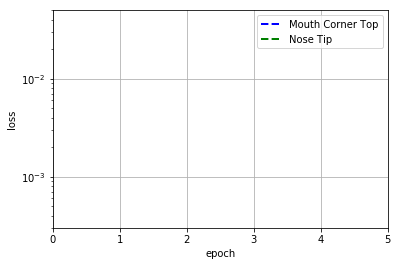

In [46]:
max_model_epochs = 0
colors = ["b", "g", "r", "c", "m", "y", "k", "w"]
for facial_model_label in facial_group_labels:
    ind_epochs = plot_learning_curves(facial_model_label['name'], colors[facial_group_labels.index(facial_model_label) % len(colors)])
    print(facial_model_label['name'])
    if ind_epochs > max_model_epochs:
          max_model_epochs = ind_epochs

plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(0.0003, 0.05)
plt.xlim(0, max_model_epochs)
plt.yscale("log")
plt.show()

